# RFM and Customer Segmentation

### Author - Lukas Fiorio

This project uses data from Tableau Public on Customer transactions to compute RFM (Recency, Frequency, Monetary Value) and then segment customer orders through kmeans clustering.
The data can be found and downloaded here: 
- https://community.tableau.com/s/contentdocument/0694T000001GnpUQAS

For this project, we download the data from a link made available through University of Washington.
- https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/SuperstoreTransaction.csv

#### Abstract

Our data consists of \~10,000 products bought in ~5,000 orders made by ~800 customers from 2014-2017.  Our goal is to engineer new features to inform customer segmentation for promotional targeting.

Specifically, we aggregate product purchases to customer orders and compute RFM, then (kmeans) cluster those orders based on our new quantitative features measuring recency, frequency, and value.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import math

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from IPython.display import display
import textwrap

import scipy.stats as ss
import statsmodels.api as sm

In [2]:
# set package options
pd.set_option('display.max_columns', None) # show all columns
plt.rc('patch', force_edgecolor = True) # set bar borders in bar plots

## Read data

Our first step is to load the transaction data for analysis. 

The data is originally sourced from Tableau Public [(available here)](https://community.tableau.com/s/contentdocument/0694T000001GnpUQAS), although in this project we source directly through University of Washington.

In [3]:
# Locate & load dataset
file = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/SuperstoreTransaction.csv"
ss_txn = pd.read_csv(file) # read file into df

After loading, we next preview the data. We see about 10,000 transactions and 21 attributes.  From inspection, it appears that most of the attributes are not numeric.

In [4]:
print(ss_txn.shape)
ss_txn.head()

(9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


#### Data Structure

Explicitly examining our data structure shows that our data is indeed mostly string data.

Conveniently, we also see that there are no missing values in our data.

*NB: although `Postal Code` is parsed as numeric, we would treat it as categorical for any analytical purposes.*

In [5]:
ss_txn.info() # data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

#### Data Grain and Feature Cardinality ####

Looking at unique values, we see that our data contains \~10,000 product transactions (`Row ID`) bought across \~5,000 orders (`Order ID`) made by \~800 customers (`Customer ID`).

Furthermore, we get a good sense of the cardinality of each column.

Those with low cardinality (e.g. `Ship Mode`, `Segment`, `Region`, etc.) may be good candidates for onehot encoding.  Features with high cardinality would likely need to be sensibly aggregated first (to avoid increasing the dimensionality of our data too significantly).

In [6]:
ss_txn.nunique() # count of unique values in each field

Row ID           9994
Order ID         5009
Order Date       1237
Ship Date        1334
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              531
State              49
Postal Code       631
Region              4
Product ID       1862
Category            3
Sub-Category       17
Product Name     1850
Sales            5825
Quantity           14
Discount           12
Profit           7287
dtype: int64

#### Numeric Attributes

Describing our numeric fields is really only useful for `Sales`, `Quantity`, `Discount`, and `Profit`.  We can't interpret much from the descriptive statistics of `Row ID` and `Postal Code`.

We see that a typical order (median) is about \\$55, with profit just under \$10.  Based on the max values, it looks like our data may skew right (as is typical for financial data).

We apply a lambda function to round the stats for readability.

In [7]:
ss_txn.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))) # data stats

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994,9994,9994,9994,9994,9994
mean,4997.5,55190.4,229.858,3.78957,0.156203,28.6569
std,2885.16,32063.7,623.245,2.22511,0.206452,234.26
min,1,1040,0.444,1,0,-6599.98
25%,2499.25,23223,17.28,2,0,1.72875
50%,4997.5,56430.5,54.49,3,0.2,8.6665
75%,7495.75,90008,209.94,5,0.2,29.364
max,9994,99301,22638.5,14,0.8,8399.98


### Data Prep

Next we'll clean up our column names and convert our date columns from objects to datetime fields

In [8]:
# rename columns for consistency
ss_txn.columns = ss_txn.columns.str.replace("-", "_") # replace hyphens
ss_txn.columns = ss_txn.columns.str.replace(" ", "_") # replace white space
ss_txn.columns = ss_txn.columns.str.lower() # lower case

# convert date columns to datetime (from object)
ss_txn['order_date'] = pd.to_datetime(ss_txn['order_date'])
ss_txn['ship_date'] = pd.to_datetime(ss_txn['ship_date'])

### Data Visualization

In this section we'll explore our dataset a bit.

First, we'll store the count of observations (transactions) by `order_date`.  From the preview, it looks like our transaction data spans four years, from Jan 2014 - Dec 2017 (`.sort_index()` is used to ensure the date values are sorted).

In [9]:
txn_count_daily = ss_txn['order_date'].value_counts().sort_index() # sort values
txn_count_daily

2014-01-03     1
2014-01-04     3
2014-01-05     1
2014-01-06     9
2014-01-07     2
              ..
2017-12-26     4
2017-12-27     2
2017-12-28    19
2017-12-29    12
2017-12-30     7
Name: order_date, Length: 1237, dtype: int64

#### Transaction Volume Trends

Plotting transaction counts by day, we get confirmation that our data spans from January 2014 thru December 2017 (4 years of transactions).  We also see that the data is pretty noisy (fairly volatile from day-to-day).

Applying a 14-day rolling average helps make the overall upward trend a bit more visible.  We also see some seasonal spikes in the latter parts of each year (September, November, December) before dropping back down in January.

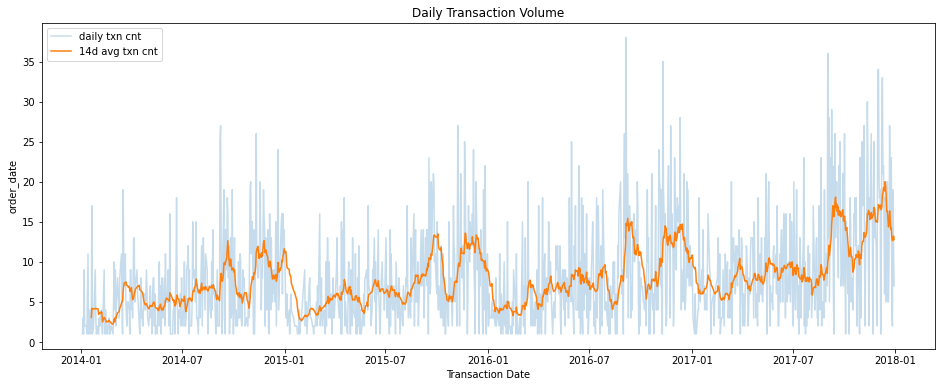

In [10]:
# set figure, axis properties
plt.figure(figsize = (16, 6))
plt.xlabel("Transaction Date")
plt.ylabel("Transaction Count")
plt.title("Daily Transaction Volume")

# draw line plots
sns.lineplot(x = txn_count_daily.index, y = txn_count_daily, alpha = 0.25, label = 'daily txn cnt');
sns.lineplot(x = txn_count_daily.index, y = txn_count_daily.rolling(14).mean(), label = '14d avg txn cnt');

#### Function: Feature Distributions

For a bit more exploration, we also define a function to show distributions of categorical and continuous variables.  Setting `plot_type` to `'distplot'` works best for continuous features, while `'countplot'` is more natural for categorical features.

In [11]:
def dist_plots(df, col_list, plot_type, n_cols=2):
    '''
    df: dataframe
    col_list: list of column names.
    plot_type: ['countplot', 'distplot']
    n_cols: number of columns in grid of plots. default = 2.
    '''
    
    # deduce nbr of rows needed for plot
    n_rows = math.ceil(len(col_list) / n_cols)

    # set figure, axis properties
    fig, ax = plt.subplots(ncols = n_cols, nrows = n_rows)
    fig.set_size_inches(16, 4 * n_rows)
    fig.tight_layout(h_pad = 6, w_pad = 12)
    
    params = {'kde': False} if plot_type == 'distplot' else {}

    # if one column only, plot just that one
    if len(col_list) == 1:
        sns.countplot(y = df[col_list[0]], ax = ax);
        ax.title.set_text('# of transactions, by ' + col_list[0]);
    
    # if multiple columns, loop & plot each
    else:
        # loop through each column & plot
        for i, col in enumerate(col_list):

            # compute row, col index
            i_row = math.floor(i / n_cols)
            i_col = i % n_cols

            # make plots
            getattr(sns, plot_type)(df[col], ax = ax[i_row][i_col], **params)
            ax[i_row][i_col].title.set_text('Transactions, by ' + col);

#### Categorical Features (low-cardinality)

Next, we identify categorical columns (those of type `'object'`), and then specifically our low-cardinality categorical columns for plotting.

In [12]:
# store object columns
obj_cols = ss_txn.select_dtypes(['object']).columns.tolist()

# count of unique values by column
ss_txn_nunique_obj = ss_txn[obj_cols].nunique().tolist()

# store object columns with cardinality of 2-10
obj_low_card = ss_txn[obj_cols].columns[
    np.where(
        (np.array(ss_txn_nunique_obj) >= 2) & 
        (np.array(ss_txn_nunique_obj) <= 10)
    )[0]]

#### Transaction Counts by Category

Transaction counts of categorical columns show that consumers are making the most purchases and office supplies are the most commonly purchased product types.

Slower shipping options are more common and region is relatively balanced (although a bit fewer purchases from customers in the South).

Does customer segment influence these other attributes at all? Are consumers more likely to buy office supplies than corporate?

We'll take a look at that next.

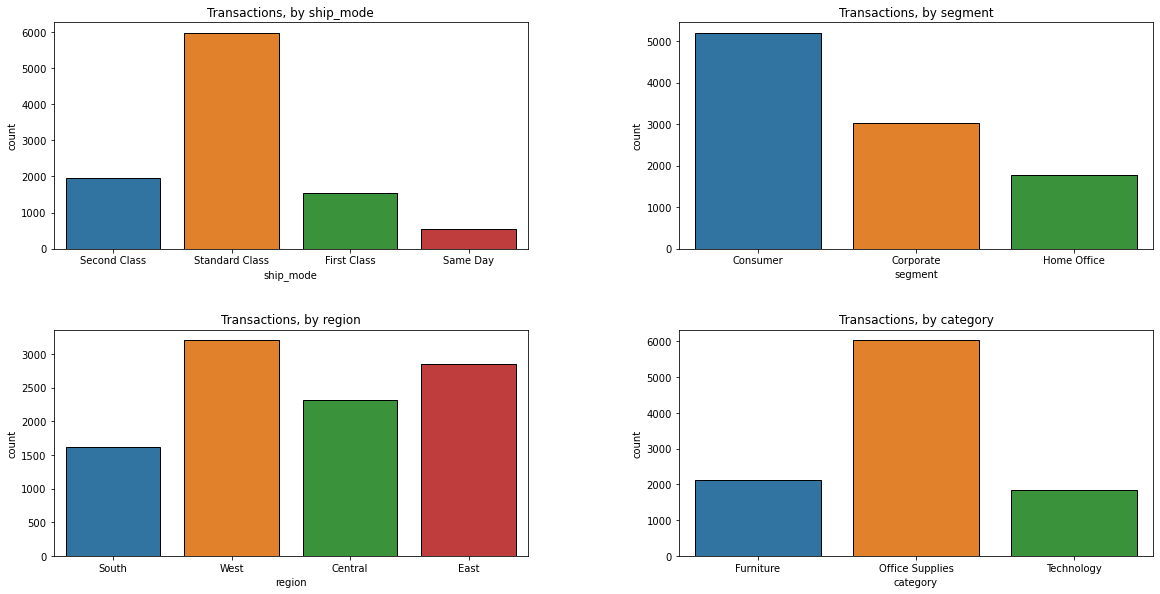

In [13]:
dist_plots(ss_txn, obj_low_card, plot_type = 'countplot', n_cols=2)

#### Function: Crosstab heatmaps

Let's define a function to make those comparisons by segment for us. To call the function, we provide a data frame, a list of columns, and the column (`segment`, in this case) to split by.

In [14]:
def ctab_heatmap(df, col_list, remove_col):

    # remove specified column from low-cardinality list (for crosstabs)
    col_list_ctab = col_list.tolist() # convert to list if not already
    col_list_ctab.remove(remove_col)

    # set figure properties
    fig, ax = plt.subplots(ncols = 3, nrows = 1)
    fig.set_size_inches(14, 8)
    fig.tight_layout(w_pad = 12)

    for i, col in enumerate(col_list_ctab):

        # calculate crosstabs
        ctab_txn_cnt = pd.crosstab(df[col], df[remove_col], margins = True, normalize = 'index')
        cbar_fmt = lambda x, pos: '{:.0%}'.format(x)

        # make plots
        sns.heatmap(ctab_txn_cnt, 
                    cmap = 'Blues', 
                    square = True, 
                    cbar_kws = {'shrink': 0.3, 'format': FuncFormatter(cbar_fmt)}, 
                    annot = True, 
                    fmt = '.0%',
                    linewidths = 1.0,
                    ax = ax[i]
                   );
        
        # set labels
        ax[i].title.set_text('Product Transaction Mix by segment\n Split by ' + col);
        ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation = 0, fontsize = 12)
        ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation = 0, fontsize = 12)

#### Transaction mix by segment

We see that there's not much difference in Product transaction mix between customer segments.  Overall, about 52% are made by consumers, 30% by corporate, and 18% by home office.

The only notable deviation that we see from that is on delivery type, where corporate is much less likely to use same day delivery than we'd otherwise expect.

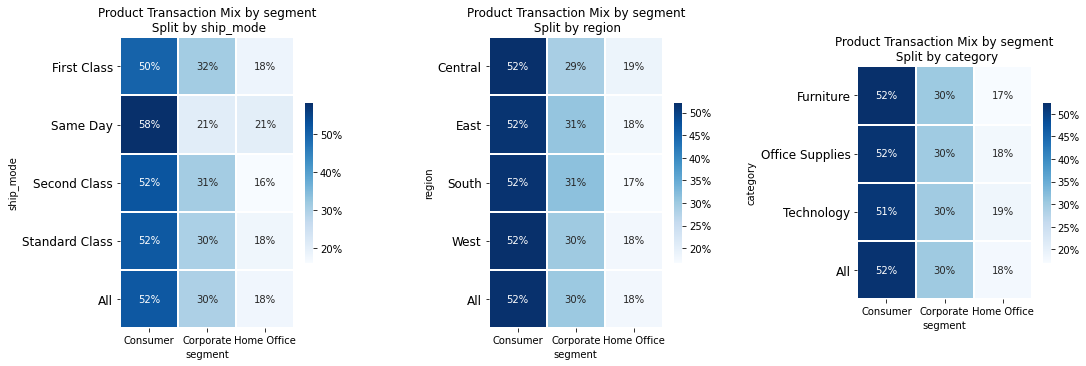

In [15]:
ctab_heatmap(ss_txn, obj_low_card, 'segment')

#### Numeric Features

And now let's also identify numeric columns to visualize those distributions.

The `row_id` and `postal_code` columns are both numeric, but we'll exclude them from our plots since those visualizations won't be helpful for us.

In [16]:
# store numeric columns; excluding row_id, postal_code
num_cols = ss_txn.select_dtypes(['float', 'int']).columns.tolist()
num_cols = list(set(num_cols) ^ set(['row_id', 'postal_code']))

#### Transaction Distribution by Numeric Features

Plotting numeric columns, we're able to learn a bit more about each.

The `discount` field appears to be a proportion between 0 and 1.  From the plot, the relationship between `sales` and `discount` isn't clear, but we can examine that next.  The primary question is whether the `sales` data is inclusive of the discount.

`profit` appears to be the closest to normally distributed and is centered just above 0 (most product transactions are profitable, although some are not).

`sales` and `quantity` both have long right tails.  `sales` in particular may be a candidate for log-transformation (depending on how we plan to make use of it).

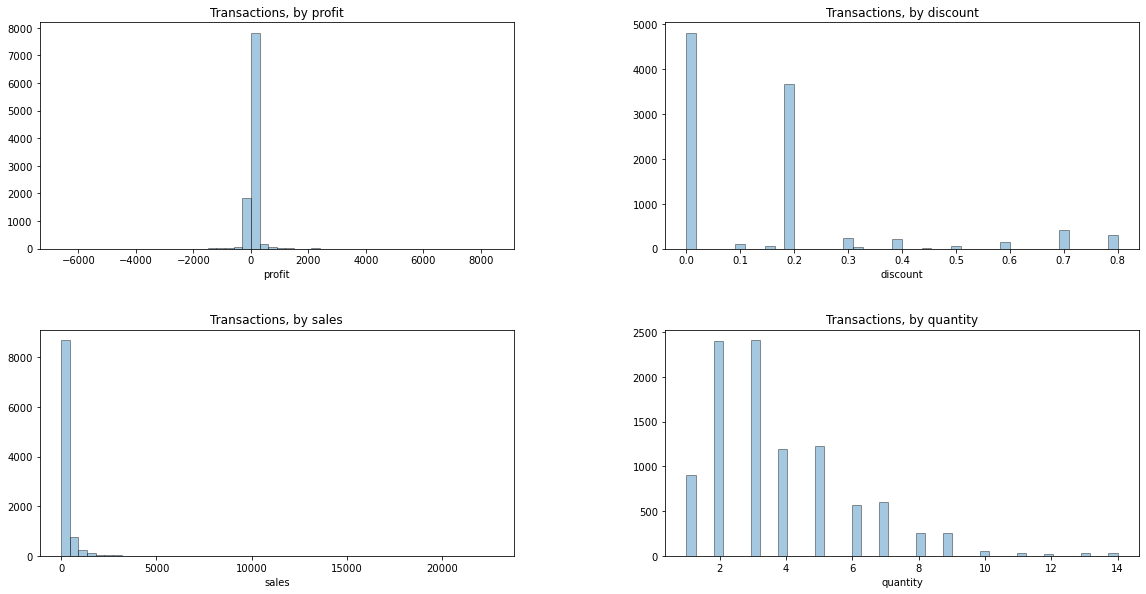

In [17]:
dist_plots(ss_txn, num_cols, plot_type = 'distplot', n_cols=2)

### Is `discount` accounted for in `sales`?

Let's check whether the sales amount includes the discount or whether the discount still needs to be taken off.

We need to control for the number of products in each order, so we'll first calculate the per-unit price (as `product_price`).

Then we'll group by `product_id` and `discount` and examine product price based on the discount field.  Lastly, we'll also add a counter field for `product_id`, to make it a bit simpler to sub-sample on product-level data.

In [18]:
# calculate per unit price
ss_txn['product_price'] = ss_txn['sales'] / ss_txn['quantity']

# columns to group by & aggregate on
group_cols = ['product_id', 'product_name', 'discount']
agg_cols = ['product_price']

# aggregate by product, discount
product_discounts = ss_txn[group_cols + agg_cols].groupby(group_cols, as_index = False).mean()

# compute counter field on product_id
product_discounts['product_num'] = (product_discounts['product_id'].
                                    transform(lambda x: pd.CategoricalIndex(x).codes)) + 1

#### Discounts <ins>are</ins> accounted for in the listed sales amounts

Now we can compare the product price on various products based on the discount field.  We'll plot product price for just the first 8 products in our dataset and inspect.

From the plots, we see that product price is **already** inclusive of the discount % off.  Going up one level, this means that the `sales` field is also already inclusive of the awarded `discount`.

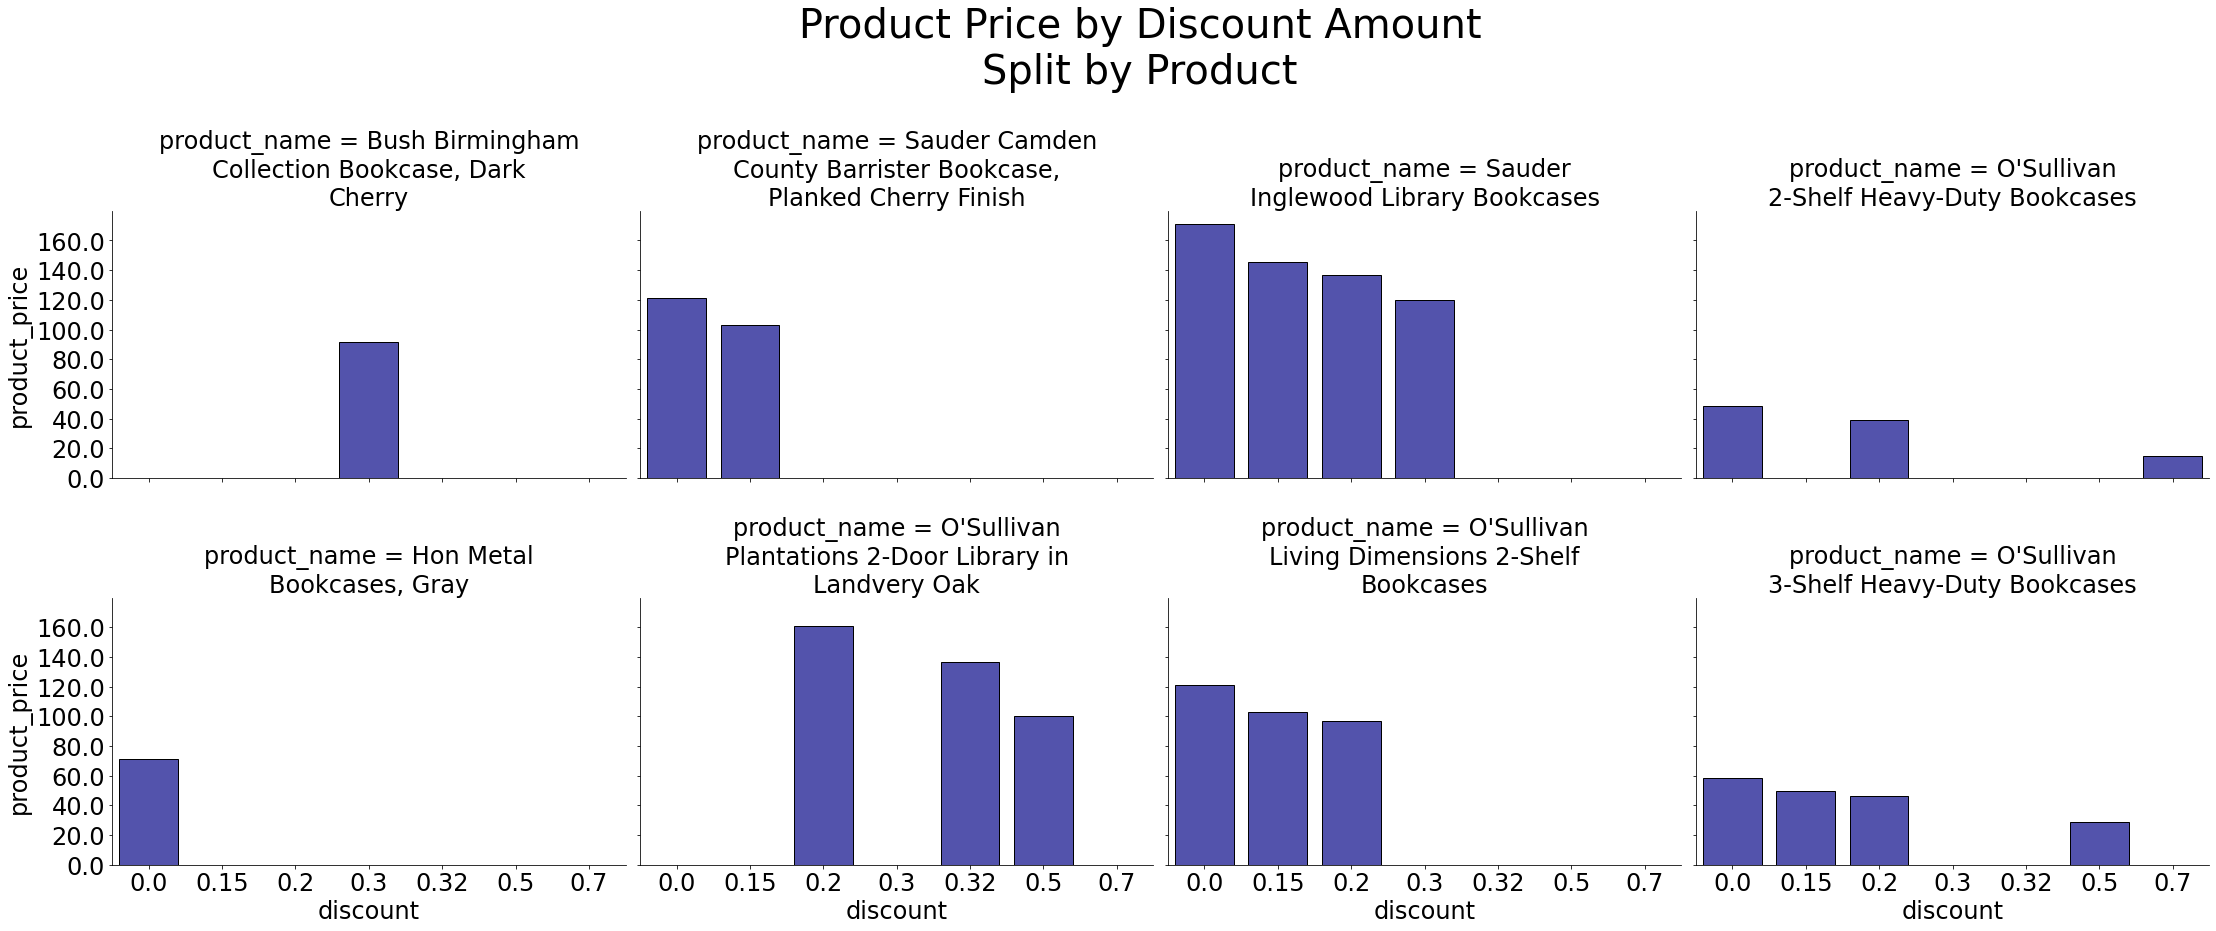

In [19]:
# make plot
ax = sns.catplot(data = product_discounts[product_discounts['product_num'] <= 8], 
            x = 'discount', y = 'product_price', 
            col = 'product_name', col_wrap = 4,
            kind = 'bar', color = 'blue', saturation = 0.35, aspect = 1.5);

# set facet grid height padding
ax.fig.tight_layout(h_pad = 10)

# set plot title
ax.fig.suptitle(
    'Product Price by Discount Amount\nSplit by Product', 
    fontsize = 40, 
    y = 1.25)

# adjust font sizes
for axes in ax.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), size = 24)
    axes.set_yticklabels(axes.get_yticks(), size = 24)
    axes.set_xlabel(axes.get_xlabel(), fontsize = 24)
    axes.set_ylabel(axes.get_ylabel(), fontsize = 24)
    axes.set_title(
        textwrap.fill(axes.get_title(loc = 'center'), 30), # wrap product name after 30 chars
        size = 24);

#### Calculate sales before discount

Let's do a bit of feature engineering based on this exploration.  We'll calculate the effect the discount rate has on both the sales amount and absolute discounts awarded.

In [20]:
# calculate absolute discount effect
ss_txn['full_product_price'] = ss_txn['product_price'] / (1 - ss_txn['discount'])
ss_txn['sales_before_discount'] = ss_txn['full_product_price'] * ss_txn['quantity']
ss_txn['discount_amt'] = ss_txn['sales_before_discount'] - ss_txn['sales']

### Function: Compare Distribution Fits of Numeric Attributes

Now let's follow up on our numeric fields that were right skewed.

From our earlier inspection, we saw that the `product_price` and `sales` features in particular had long right tails.  Next we define a function to apply transformation functions (log and boxcox), then compare the original & transformed distributions to the normal distribution.

We'll make comparisons both statistically (using a kolmogorov-smirnov test) and visually.

In [21]:
# function to graphically and statistically compare distribution transformations
def compare_transformations(df, col, const=0, base=math.e):
    
    # set plot and axis properties
    fig, axs = plt.subplots(ncols = 3, nrows = 2)
    fig.set_size_inches(12, 8)
    fig.tight_layout(pad=6.0)
    axs[0][0].title.set_text('QQ plot: ' + col)
    axs[0][1].title.set_text('QQ plot: log(' + col + ')')
    axs[0][2].title.set_text('QQ plot: boxcox(' + col + ')')
    axs[1][0].title.set_text('distribution: ' + col)
    axs[1][1].title.set_text('distribution: log(' + col + ')')
    axs[1][2].title.set_text('distribution: boxcox(' + col + ')')

    ## store transformations
    
    # optionally specify constant to avoid value=0 errors.
    # optionally specify log-base 
    # (fyi, formula to change log-base: https://en.wikipedia.org/wiki/Logarithm#Change_of_base)
    log_col = np.log(df[col] + const) / np.log(base)
    
    # ignore np.NaN warnings specifically for boxcox transformation
    with np.errstate(invalid='ignore'): 
        # optionally specify a constant to avoid value=0 errors
        boxcox_col = pd.Series(ss.boxcox(df[col] + const)[0])
    
    # make QQ plots
    sm.qqplot(df[col], line = 'q', ax = axs[0][0])
    sm.qqplot(log_col, line = 'q', ax = axs[0][1])
    sm.qqplot(boxcox_col, line = 'q', ax = axs[0][2])

    # make distribution plots
    sns.distplot(df[col], kde=False, ax = axs[1][0])
    sns.distplot(log_col, kde=False, ax = axs[1][1])
    sns.distplot(boxcox_col, kde=False, ax = axs[1][2]);
    
    # normalize columns for ks test
    z_col = (df[col] - df[col].mean()) / df[col].std()
    z_col_log = (log_col - log_col.mean()) / log_col.std()
    z_col_boxcox = (boxcox_col - boxcox_col.mean()) / boxcox_col.std()
 
    # print results of ks test
    print(col + ':')
    print(ss.kstest(z_col.dropna(), 'norm'))
    
    print('\nlog(' + col + '):')
    print(ss.kstest(z_col_log.dropna(), 'norm'))
    
    print('\nboxcox(' + col + '):')
    print(ss.kstest(z_col_boxcox.dropna(), 'norm'))

#### `product_price` distribution

H<sub>0</sub>: The sample **is** drawn from a Normal distribution.

Given the p-values, we reject that comparison.  Even after the log and box-cox transformations, it appears the tails are still too short to follow a normal distribution, although they are much closer.

product_price:
KstestResult(statistic=0.33582797782486207, pvalue=0.0)

log(product_price):
KstestResult(statistic=0.06858018603781363, pvalue=2.581943709557018e-41)

boxcox(product_price):
KstestResult(statistic=0.059827603705515875, pvalue=1.5434836131453933e-31)


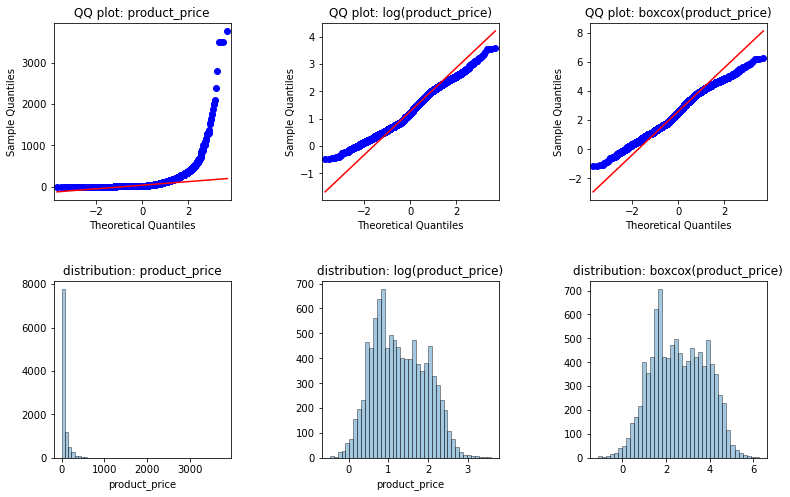

In [22]:
compare_transformations(ss_txn, 'product_price', base = 10)

#### `sales` distribution

H<sub>0</sub>: The sample **is** drawn from a Normal distribution.

Similar to `product_price`, it appears that `sales` also does not follow a normal distribution even after the transformation (tails are still too short).

That said - **in both cases, the log and boxcox transformations noticeably improved the right skew of the distributions.**

sales:
KstestResult(statistic=0.35643523525465687, pvalue=0.0)

log(sales):
KstestResult(statistic=0.041039722258109534, pvalue=4.607669196316846e-15)

boxcox(sales):
KstestResult(statistic=0.03368198451142412, pvalue=2.760500391508567e-10)


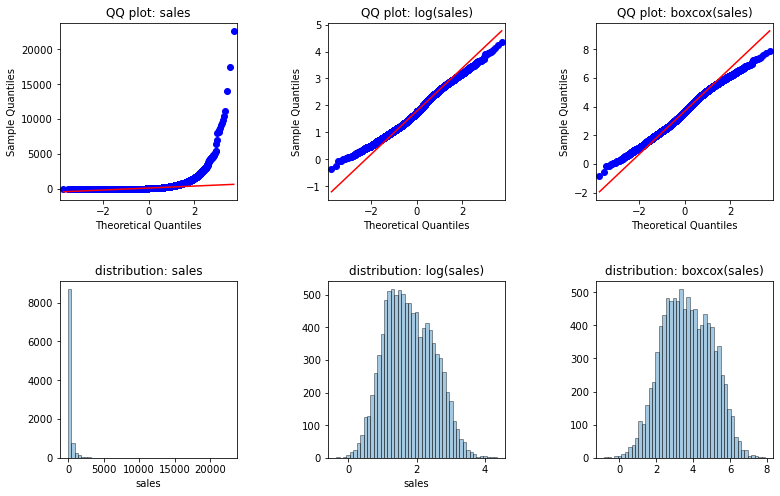

In [23]:
compare_transformations(ss_txn, 'sales', base = 10)

## Calculate RFM

### Aggregate the data: *Customer Order Days*

Now that we've gotten a sense for our dataset, we'll aggregate to the "customer order day" level.  Each record in our dataset will represent a unique customer and order date, rather than a unique customer product transaction.

We'll start by grouping on `customer_id` and `order_date`, then summing up total sales (\$ and #) and counting distinct orders and products.

In [24]:
# group by customer id and order date
# aggregate $ sales, # of total products, # of distinct products, # of distinct orders
ss_txn_agg = ss_txn.groupby(['customer_id', 'order_date']).agg({
    'sales': 'sum',
    'quantity': 'sum', 
    'product_id': 'nunique',
    'order_id': 'nunique'
    })
ss_txn_agg = ss_txn_agg.reset_index()

Previewing the data, we see several customer order dates and the corresponding sales attributes we created.

In [25]:
ss_txn_agg.head() # preview the data

,customer_id,order_date,sales,quantity,product_id,order_id
0,AA-10315,2014-03-31,726.548,4,2,1
1,AA-10315,2014-09-15,29.500,5,2,1
2,AA-10315,2015-10-04,26.960,2,1,1
3,AA-10315,2016-03-03,4406.072,14,4,1
4,AA-10315,2017-06-29,374.480,5,2,1


Examining our new structure, we see we've aggregated down to about half the row count that we began with (4,492 vs 9,994).

We should note that this is <ins>not</ins> identical to grouping on customer orders, since a customer could make multiple orders on the same day.  In fact, we know from earlier in our exploration that there were 5,009 unique orders made, which is slightly more than the 4,492 records that we've aggregated to.

In [26]:
ss_txn_agg.info() # data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  4992 non-null   object        
 1   order_date   4992 non-null   datetime64[ns]
 2   sales        4992 non-null   float64       
 3   quantity     4992 non-null   int64         
 4   product_id   4992 non-null   int64         
 5   order_id     4992 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 234.1+ KB


In fact, we can show exactly where the *customer order* level would not match the *customer order days* level.  Below we filter on just those records (where distinct count of `order_id` - for a given customer & day - is more than one).

In [27]:
# examine records associated with an multi-order days
ss_txn_agg[ss_txn_agg['order_id'] > 1]

,customer_id,order_date,sales,quantity,product_id,order_id
122,AG-10330,2017-12-22,290.680,17,4,2
477,BE-11455,2016-05-06,165.976,12,4,2
630,BP-11185,2017-12-10,477.724,17,5,2
719,BW-11200,2016-10-27,802.502,26,5,2
760,CB-12025,2017-09-11,506.860,14,3,2
1062,CS-12355,2014-08-15,306.540,13,3,2
1672,EM-13960,2015-10-01,684.560,10,3,2
1946,GT-14710,2016-02-19,358.280,7,3,2
2057,HM-14860,2017-08-04,20.070,6,3,2
2127,JB-15400,2015-09-03,358.440,4,3,2


### Engineer Recency, Frequency, Monetary (RFM) metrics

Next, we will use our aggregated data to calculate the recency, frequency, and value associated with each customer order day.

We start by splitting on `customer_id` and taking the 90-day rolling sum across order dates for `sales`, `quantity`, and `product_id`.  For each customer order day, we've now calculated the total sales, # of items ordered, and # of unique products ordered over the past 90 days.

In [28]:
# take rolling sums at each check point, examining past 90 days

# sales $
roll_sum_sales = ss_txn_agg.groupby('customer_id').\
    rolling(window = '90D', on = 'order_date')['sales'].sum()

# item cnt
roll_cnt_products = ss_txn_agg.groupby('customer_id').\
    rolling(window = '90D', on = 'order_date')['quantity'].sum()

# distinct product cnt
roll_cnt_products_distinct = ss_txn_agg.groupby('customer_id').\
    rolling(window = '90D', on = 'order_date')['product_id'].sum()

Now we compute our recency metric: how long (in days) since the customer made their last order.  In cases where there is no prior observed order, we assume that the last order was made 4 years prior (the windowing range of our dataset).

A better approach for this imputation would be to make an inference about the "time since last order" for customers' first order within the window based on other visible attributes specific to the customer.  Namely, when within the window do they make their first purchase and what is the typical gap they have between orders.

We leave this imputation to a future iteration of this work.

In [29]:
# compute recency metric (days since customers last txn)
roll_last_order = ss_txn_agg.groupby('customer_id')['order_date'].diff(periods = 1).dt.days

# calculate max observed recency, for imputation
last_order_imputation = (ss_txn_agg['order_date'].max() - ss_txn_agg['order_date'].min()).days

Next we'll combine each of our data series into a single dataframe.

In [30]:
# combine rolling sum and recency metrics
ss_txn_roll = pd.concat([roll_sum_sales, roll_cnt_products, roll_cnt_products_distinct], axis = 1)
ss_txn_roll.columns = ['dollar_roll_sum_90d', 'product_roll_sum_90d', 'distinct_product_roll_sum_90d']
ss_txn_roll = ss_txn_roll.reset_index()

# if first visit, fill w max date range
ss_txn_roll['last_visit_ndays'] = roll_last_order.fillna(last_order_imputation) 

And lastly, we'll merge the RFM-info back into the *Customer Order Days* dataframe we aggregated earlier.

In [31]:
# inner merge agg & roll (on customer_id, order_date)
ss_txn_rfm = ss_txn_agg.merge(
    ss_txn_roll, 
    how = "inner", 
    on = ['customer_id', 'order_date'], 
    validate = 'one_to_one'
    )

# preview rfm data
ss_txn_rfm.head()

,customer_id,order_date,sales,quantity,product_id,order_id,dollar_roll_sum_90d,product_roll_sum_90d,distinct_product_roll_sum_90d,last_visit_ndays
0,AA-10315,2014-03-31,726.548,4,2,1,726.548,4.0,2.0,1457.0
1,AA-10315,2014-09-15,29.500,5,2,1,29.500,5.0,2.0,168.0
2,AA-10315,2015-10-04,26.960,2,1,1,26.960,2.0,1.0,384.0
3,AA-10315,2016-03-03,4406.072,14,4,1,4406.072,14.0,4.0,151.0
4,AA-10315,2017-06-29,374.480,5,2,1,374.480,5.0,2.0,483.0


Previewing the data structure, we see no null values and the same record count (4,992 unique customer order days) as earlier - but now with RFM metrics included.

In [32]:
ss_txn_rfm.info() # data structure of rfm

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4992 entries, 0 to 4991
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    4992 non-null   object        
 1   order_date                     4992 non-null   datetime64[ns]
 2   sales                          4992 non-null   float64       
 3   quantity                       4992 non-null   int64         
 4   product_id                     4992 non-null   int64         
 5   order_id                       4992 non-null   int64         
 6   dollar_roll_sum_90d            4992 non-null   float64       
 7   product_roll_sum_90d           4992 non-null   float64       
 8   distinct_product_roll_sum_90d  4992 non-null   float64       
 9   last_visit_ndays               4992 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 429.0+ KB


## Segment using kmeans

Before normalizing our data and fitting a kmeans model, we'll start by making a copy of the dataset.  This will allow us to (in the end) join our kmeans data back to the original, unscaled data for easier interpretability.

In [33]:
# make a copy of the dataset (no pointer)
ss_txn_rfm_scaled = ss_txn_rfm.copy()

#### Normalize the data

Normalizing the data is important for kmeans as it is a distance-based algorithm; if data are not scaled, then distances will not be appropriately weighted.

We will select relevant numeric columns and z-scale them for use in kmeans (convert units into "standard deviations away from the mean").

In [34]:
# normalize the data
scale_cols = ss_txn_rfm_scaled.columns.difference(['customer_id', 'order_date'], sort = False)
ss_txn_rfm_scaled[scale_cols] = StandardScaler().fit_transform(ss_txn_rfm_scaled[scale_cols]) 

#### Initialize & fit kmeans

In this case, we fit kmeans on a 2-cluster solution.

In [35]:
n_clusters = 2 # set number of clusters

X = ss_txn_rfm_scaled[scale_cols]
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # initialize kmeans
kmeans.fit(X) # train the model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

Now that our model is fit, we make cluster assignments for each customer order day in our original data.

In [36]:
# assign cluster to each row of the original RFM data
ss_txn_rfm['cluster'] = kmeans.predict(X) 

Previewing the data shows the output looks as expected.

In [37]:
ss_txn_rfm.head() # preview the data

,customer_id,order_date,sales,quantity,product_id,order_id,dollar_roll_sum_90d,product_roll_sum_90d,distinct_product_roll_sum_90d,last_visit_ndays,cluster
0,AA-10315,2014-03-31,726.548,4,2,1,726.548,4.0,2.0,1457.0,0
1,AA-10315,2014-09-15,29.500,5,2,1,29.500,5.0,2.0,168.0,0
2,AA-10315,2015-10-04,26.960,2,1,1,26.960,2.0,1.0,384.0,0
3,AA-10315,2016-03-03,4406.072,14,4,1,4406.072,14.0,4.0,151.0,1
4,AA-10315,2017-06-29,374.480,5,2,1,374.480,5.0,2.0,483.0,0


### Examine cluster centers

- **cluster**: <ins>*Large, follow-up Transaction Days*</ins>
  - The smaller cluster (23% of customer order days).  Defining characteristic: Larger transaction days with more product types.
  - Transactions consist of more products and items.
    - However, the item::product ratio is similar to the other cluster, indicating that larger transaction size is primarily driven by the # of distinct products purchased (not a higher # of each product)
  - Prior transactions are more recent, although not overwhelmingly so.
  - Larger rolling window spend, but mostly (not entirely) driven by the transaction itself.
- **cluster**: <ins>*Small, stand-alone Transaction Days*</ins>
  - The larger cluster (77% of observations).  Defining characteristic: Smaller transaction days with fewer product types.
  - As opposed to the other cluster, these transactions tend to be smaller (due to fewer products purchased), and a bit further removed from prior transactions.

Cluster centers, based on the normalized attributes.  Units are in standard deviations, with negative values indicating a below average score and positive values indicating above average.

In [38]:
# examine cluster centers
pd.DataFrame(kmeans.cluster_centers_, columns=scale_cols)

,sales,quantity,product_id,order_id,dollar_roll_sum_90d,product_roll_sum_90d,distinct_product_roll_sum_90d,last_visit_ndays
0,-0.226679,-0.374189,-0.377432,-0.022620,-0.260502,-0.403169,-0.394579,0.047150
1,0.748822,1.236115,1.246828,0.074724,0.860555,1.331847,1.303471,-0.155759


The relative size of each cluster (*percent of customer order days*).  Small, stand-alone transaction days are much more common.

In [39]:
# relative size of each cluster
round(ss_txn_rfm['cluster'].value_counts(normalize = True).sort_index(), 2)

0    0.77
1    0.23
Name: cluster, dtype: float64

The cluster centers, based on the original data values.

In [40]:
# columns to examine means by cluster
display(ss_txn_rfm.groupby(['cluster']).mean())

,sales,quantity,product_id,order_id,dollar_roll_sum_90d,product_roll_sum_90d,distinct_product_roll_sum_90d,last_visit_ndays
cluster,,,,,,,,
0,243.214411,5.253396,1.466562,1.002090,334.338481,7.070272,1.963166,413.848485
1,1173.690802,15.260309,3.756014,1.007732,1640.038205,21.866838,5.458763,312.639175


### Aggregate the data: *Customers*

Above we've segmented by customer order days.  Now let's do the same for ***customers***.

We'll start by grouping on `customer_id`, and aggregating on the customer order day RFM segmentation data.

*Note: In aggregating `cluster`, we want to count the cases (per customer) where `cluster = 1`.  Since the only values that `cluster` takes are `{0, 1}`, using `sum()` works just fine.*

In [41]:
# aggregate order day, RFM to customer level.
# nb: cluster: {0, 1} >> {small, large}
ss_cust_rfm = ss_txn_rfm.groupby(['customer_id']).agg({
    'order_date': 'count',
    'cluster': 'sum'
})

# rename attributes
ss_cust_rfm = ss_cust_rfm.rename(columns={
    'order_date': 'order_days_cnt', 
    'cluster': 'high_rfm_order_days'
    })

# calculate % of order days in high RFM cluster
ss_cust_rfm['high_rfm_order_day_pct'] = ss_cust_rfm['high_rfm_order_days'] / ss_cust_rfm['order_days_cnt']

# preview data
ss_cust_rfm.head()

,order_days_cnt,high_rfm_order_days,high_rfm_order_day_pct
customer_id,,,
AA-10315,5,1,0.2
AA-10375,9,0,0.0
AA-10480,4,2,0.5
AA-10645,6,3,0.5
AB-10015,3,0,0.0


### Additional feature engineering

Now that we've aggregated the order day RFM data to the customer level, we'll also want to aggregate some attributes from the original product transaction grain up to the customer level.

Before we make those aggregations, we'll engineer a few new features.  First, how recently each product transaction was made (assuming today is the day after our data ends, 2017-12-31).

In [42]:
# calculate txn recency
ss_txn['days_since_order'] = (ss_txn['order_date'].max() - ss_txn['order_date']).dt.days + 1

Next, we'll onehot encode columns that we want to aggregate to the customer level.  From our data exploration earlier, we found that - aside from `ship_mode` - the information captured by `segment` overlapped quite heavily.

We decide not to include the `region` and `category` features in our customer aggregation for this reason.

In [43]:
onehot_cols = ['segment', 'ship_mode']

# initialize class and fit our data
onehot = OneHotEncoder(sparse = False, drop = None) # initialize one-hot-encoder
onehot.fit(ss_txn[onehot_cols])

# properly name columns
onehot_names = onehot.get_feature_names(onehot_cols).astype(str)
onehot_names = np.char.replace(onehot_names, ".", "_") # replace '.'
onehot_names = np.char.replace(onehot_names, " ", "_") # replace " "
onehot_names = np.char.lower(onehot_names) # lowercase

# onehot.transform to create encoded variables
# note: wrap in pd.dataframe (default returns np array)
ss_txn[onehot_names] = pd.DataFrame(onehot.transform(ss_txn[onehot_cols]), columns = onehot_names)

### Customer-level Aggregation

And now we'll aggregate our various transaction-level metrics up to the customer level.

In particular, we'll be aggregating data on sales volume (including discounts and profit), sales recency, shipping method, and customer business segment.

In [44]:
# aggregate product txn to customer
ss_cust_txn = ss_txn.groupby(['customer_id']).agg({
    'order_id': 'count',
    'profit': 'sum',
    'discount_amt': 'sum',
    'sales': 'sum',
    'sales_before_discount': 'sum',
    'segment_corporate': 'sum',
    'segment_home_office': 'sum',
    'ship_mode_same_day': 'sum',
    'days_since_order': 'min'
})

# rename columns
ss_cust_txn = ss_cust_txn.rename(columns={
    'order_id': 'product_order_cnt', 
    'profit': 'profit_amt',
    'discount_amt': 'discount_amt',
    'sales': 'sales_amt_after_discount',
    'sales_before_discount': 'sales_amt_before_discount',
    'segment_corporate': 'order_cnt_seg_corp',
    'segment_home_office': 'order_cnt_seg_home',
    'ship_mode_same_day': 'order_cnt_ship_same_day',
    'days_since_order': 'days_since_recent_order'
    })

Our product transaction data is now aggregated to the customer-level.  Let's normalize a few of our metrics based on total sales and order volume.  That way the magnitude of profits and discounts won't conflate with overall sales magnitude.

In [45]:
ss_cust_txn['profit_rate'] = ss_cust_txn['profit_amt'] / ss_cust_txn['sales_amt_after_discount']
ss_cust_txn['discount_rate'] = ss_cust_txn['discount_amt'] / ss_cust_txn['sales_amt_before_discount']

ss_cust_txn['seg_rate_corp'] = ss_cust_txn['order_cnt_seg_corp'] / ss_cust_txn['product_order_cnt']
ss_cust_txn['seg_rate_home'] = ss_cust_txn['order_cnt_seg_home'] / ss_cust_txn['product_order_cnt']

ss_cust_txn['ship_rate_same_day'] = ss_cust_txn['order_cnt_ship_same_day'] / ss_cust_txn['product_order_cnt']

Now let's join the customer-level RFM segment data with the aggregated transaction data.

In [46]:
ss_cust = ss_cust_rfm.merge(ss_cust_txn, on='customer_id', how='left')

# preview data
print('shape:', ss_cust.shape)
ss_cust.head()

shape: (793, 17)


,order_days_cnt,high_rfm_order_days,high_rfm_order_day_pct,product_order_cnt,profit_amt,discount_amt,sales_amt_after_discount,sales_amt_before_discount,order_cnt_seg_corp,order_cnt_seg_home,order_cnt_ship_same_day,days_since_recent_order,profit_rate,discount_rate,seg_rate_corp,seg_rate_home,ship_rate_same_day
customer_id,,,,,,,,,,,,,,,,,
AA-10315,5,1,0.2,11,-362.8825,1269.910,5563.560,6833.47,0.0,0.0,0.0,185,-0.065225,0.185837,0.0,0.0,0.000000
AA-10375,9,0,0.0,15,277.3824,43.180,1056.390,1099.57,0.0,0.0,0.0,20,0.262576,0.039270,0.0,0.0,0.000000
AA-10480,4,2,0.5,12,435.8274,3.888,1790.512,1794.40,0.0,0.0,1.0,260,0.243409,0.002167,0.0,0.0,0.083333
AA-10645,6,3,0.5,18,857.8033,719.775,5086.935,5806.71,0.0,0.0,0.0,56,0.168629,0.123956,0.0,0.0,0.000000
AB-10015,3,0,0.0,6,129.3465,15.334,886.156,901.49,0.0,0.0,0.0,416,0.145964,0.017010,0.0,0.0,0.000000


Examining the data structure, we see all 793 customers, with no null values.

In [47]:
# data structure
ss_cust.info()

<class 'pandas.core.frame.DataFrame'>
Index: 793 entries, AA-10315 to ZD-21925
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   order_days_cnt             793 non-null    int64  
 1   high_rfm_order_days        793 non-null    int32  
 2   high_rfm_order_day_pct     793 non-null    float64
 3   product_order_cnt          793 non-null    int64  
 4   profit_amt                 793 non-null    float64
 5   discount_amt               793 non-null    float64
 6   sales_amt_after_discount   793 non-null    float64
 7   sales_amt_before_discount  793 non-null    float64
 8   order_cnt_seg_corp         793 non-null    float64
 9   order_cnt_seg_home         793 non-null    float64
 10  order_cnt_ship_same_day    793 non-null    float64
 11  days_since_recent_order    793 non-null    int64  
 12  profit_rate                793 non-null    float64
 13  discount_rate              793 non-null    

Now let's specify the subset of columns to include in cluster analysis.  We'll store them in a separate dataframe.

In [48]:
kmean_cols = [
    'order_days_cnt', 
    'high_rfm_order_day_pct',
    'sales_amt_after_discount', 
    'profit_rate',
    'discount_rate',
    'seg_rate_corp',
    'seg_rate_home',
    'ship_rate_same_day',
    'days_since_recent_order'
    ]

# hard copy (no link)
ss_cust_kmeans = ss_cust[kmean_cols].copy()

Standardize the data before clustering.  As we did for our RFM transaction clustering, we must take this step to ensure that attributes with larger magnitude values are not overweighted (kmeans is a distance-based algorithm).

In [49]:
# normalize the data
scale_cols = ss_cust_kmeans.columns.difference(['customer_id'], sort = False)
ss_cust_kmeans[scale_cols] = StandardScaler().fit_transform(ss_cust_kmeans[scale_cols]) 

Previewing data that kmeans will be fit on, and verifying our data looks as expected.  We can proceed next to fitting the model.

In [50]:
ss_cust_kmeans.head()

,order_days_cnt,high_rfm_order_day_pct,sales_amt_after_discount,profit_rate,discount_rate,seg_rate_corp,seg_rate_home,ship_rate_same_day,days_since_recent_order
customer_id,,,,,,,,,
AA-10315,-0.511536,-0.108984,1.015112,-0.915329,0.064502,-0.650921,-0.479017,-0.468613,0.199889
AA-10375,1.068397,-1.080886,-0.700590,0.794657,-1.091936,-0.650921,-0.479017,-0.468613,-0.686762
AA-10480,-0.906519,1.348868,-0.421139,0.694675,-1.384686,-0.650921,-0.479017,0.263042,0.602912
AA-10645,-0.116552,1.348868,0.833680,0.304578,-0.423750,-0.650921,-0.479017,-0.468613,-0.493311
AB-10015,-1.301502,-1.080886,-0.765391,0.186344,-1.267573,-0.650921,-0.479017,-0.468613,1.441199


### kmeans clustering

Now we initialize and fit kmeans on scaled data using 4-cluster solution.  

After fitting the model, we make our predictions on the original, unscaled data (for easier interpretability).

In [51]:
n_clusters = 4 # set number of clusters

X = ss_cust_kmeans[scale_cols]
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # initialize kmeans
kmeans.fit(X) # train the model

# assign cluster to each row of the original RFM data
ss_cust['cluster'] = kmeans.predict(X) 

Preview of customer-level data, including cluster assignments.  The data looks as expected and so we'll next proceed to cluster profiling.

In [52]:
ss_cust.head()

,order_days_cnt,high_rfm_order_days,high_rfm_order_day_pct,product_order_cnt,profit_amt,discount_amt,sales_amt_after_discount,sales_amt_before_discount,order_cnt_seg_corp,order_cnt_seg_home,order_cnt_ship_same_day,days_since_recent_order,profit_rate,discount_rate,seg_rate_corp,seg_rate_home,ship_rate_same_day,cluster
customer_id,,,,,,,,,,,,,,,,,,
AA-10315,5,1,0.2,11,-362.8825,1269.910,5563.560,6833.47,0.0,0.0,0.0,185,-0.065225,0.185837,0.0,0.0,0.000000,1
AA-10375,9,0,0.0,15,277.3824,43.180,1056.390,1099.57,0.0,0.0,0.0,20,0.262576,0.039270,0.0,0.0,0.000000,1
AA-10480,4,2,0.5,12,435.8274,3.888,1790.512,1794.40,0.0,0.0,1.0,260,0.243409,0.002167,0.0,0.0,0.083333,1
AA-10645,6,3,0.5,18,857.8033,719.775,5086.935,5806.71,0.0,0.0,0.0,56,0.168629,0.123956,0.0,0.0,0.000000,1
AB-10015,3,0,0.0,6,129.3465,15.334,886.156,901.49,0.0,0.0,0.0,416,0.145964,0.017010,0.0,0.0,0.000000,1


### Cluster profiling

Our goal is to create a clear summary of each cluster, both visually and in table form.  We'll start by taking cluster averages across each of our KPIs, and joining the info together into a dataframe.

In [53]:
# calculate cluster size & means
clus_size = pd.DataFrame(round(ss_cust['cluster'].value_counts(normalize = True).sort_index(), 2)).T
clus_means = ss_cust.groupby(['cluster']).mean().apply(lambda s: s.apply(lambda x: format(x, 'g'))).T

# concat into single df
clus_summ = pd.concat([clus_size, clus_means], ignore_index = False)

Next, we'll create functions to format our table summary output.  These will make it easier to identify which cluster scored the highest and lowest on each metric.

Specifically, we'll highlight the cluster with the max value for each KPI in **<font color='lightsteelblue'>blue</font>** and the min value **<font color='salmon'>red</font>**.

In [54]:
# highlight max val in series (light-blue)
def highlight_max(s):

    # handle cases when max value is positive OR negative
    is_max = \
        ((s >= s.max() * 0.9) & (s.max() >= 0)) |\
        ((s >= s.max() * 1.1) & (s.max() < 0))

    return ['background-color: lightsteelblue' if v else '' for v in is_max]

In [55]:
# highlight min val in series (light-red)
def highlight_min(s):

    # handle cases when min value is positive OR negative
    is_min = \
        ((s <= s.min() * 1.1) & (s.min() >= 0)) |\
        ((s <= s.min() * 0.9) & (s.min() < 0))

    return ['background-color: mistyrose' if v else '' for v in is_min]

## Examine customer clusters

And now we examine each of our segments to better understand our customer base and how we might approach each.

**<ins>*Unprofitable Discount hunters*</ins>**
- The smallest cluster (11% of customers).  Defining characteristics: These customers buy products on massive discount (42% off, on average) and are extremely unprofitable as a result (-26% profit margin). They purchase relatively infrequently, but spend big (and save big) when they do.

**<ins>*Home-office shoppers*</ins>**
- A relatively small cluster (17% of customers).  Defining characteristics: These customers shop exclusively in the home-office segment; beyond that they are fairly typical.

**<ins>*High value customers*</ins>**
- A mid-sized cluster (25% of customers).  Defining characteristics: These customers shop often and spend the most.  They represent 63% of company profit, while only 25% of customers.

**<ins>*Core customers*</ins>**
- The biggest cluster (47% of customers).  Defining characteristics: Nearly half of customers, this group represents  typical shopping behavior.  They shop less often and tend to make smaller purchases when they do. While not the biggest spenders, they still turn a healthy profit (34% of total).

In [56]:
# rename cluster centers to segment names
clus_summ = clus_summ.rename(
    columns = {0: 'discount_hunters', 
               1: 'home_office shoppers', 
               2: 'high_value_customers', 
               3: 'core_customers'},
    index = {'cluster': 'cluster_size'})

# summarize output by cluster
clus_summ.apply(pd.to_numeric).style\
    .apply(highlight_max, axis = 1)\
    .apply(highlight_min, axis = 1)\
    .set_precision(2)

,discount_hunters,home_office shoppers,high_value_customers,core_customers
cluster_size,0.25,0.45,0.12,0.18
order_days_cnt,6.69,6.57,4.51,6.29
high_rfm_order_days,1.71,1.51,0.89,1.42
high_rfm_order_day_pct,0.25,0.22,0.19,0.21
product_order_cnt,13.50,13.20,8.94,12.35
profit_amt,549.90,465.13,-568.92,478.41
discount_amt,506.43,564.38,1692.12,710.51
sales_amt_after_discount,3155.34,2949.00,2019.36,3008.53
sales_amt_before_discount,3661.77,3513.37,3711.48,3719.04
order_cnt_seg_corp,13.50,0.00,3.12,0.00


### Cluster Data Visualization

The table above shows us the detailed information on each segment, but let's also plot the data to easily digest the key traits.

The function below creates bar plot crosstabs, provided a dataframe and columns to plot.  We'll use it to split by our customer data by segment.

In [57]:
def bar_plots(df, x, col_list, n_cols):

    # deduce nbr of rows needed for plot
    n_rows = math.ceil(len(col_list) / n_cols)

    # set figure, axis properties
    fig, ax = plt.subplots(ncols = n_cols, nrows = n_rows)
    fig.set_size_inches(16, 2 * n_rows)
    fig.tight_layout(h_pad = 6, w_pad = 12)

    for i, col in enumerate(col_list):
        i_row = math.floor(i / n_cols)
        i_col = i % n_cols
        sns.barplot(data = df, x = x, y = col, 
                    orient = 'v', ci = None, ax = ax[i_row][i_col])
        ax[i_row][i_col].title.set_text(col + ', by Customer segment')

### Plot cluster summary output

Data visualization across the subset of attributes that were used to find cluster centers clearly shows how the segments differ.

We can easily see the defining characteristics of each segment (with "core customers" as the notable exception; they represent the core, standard customer after all).

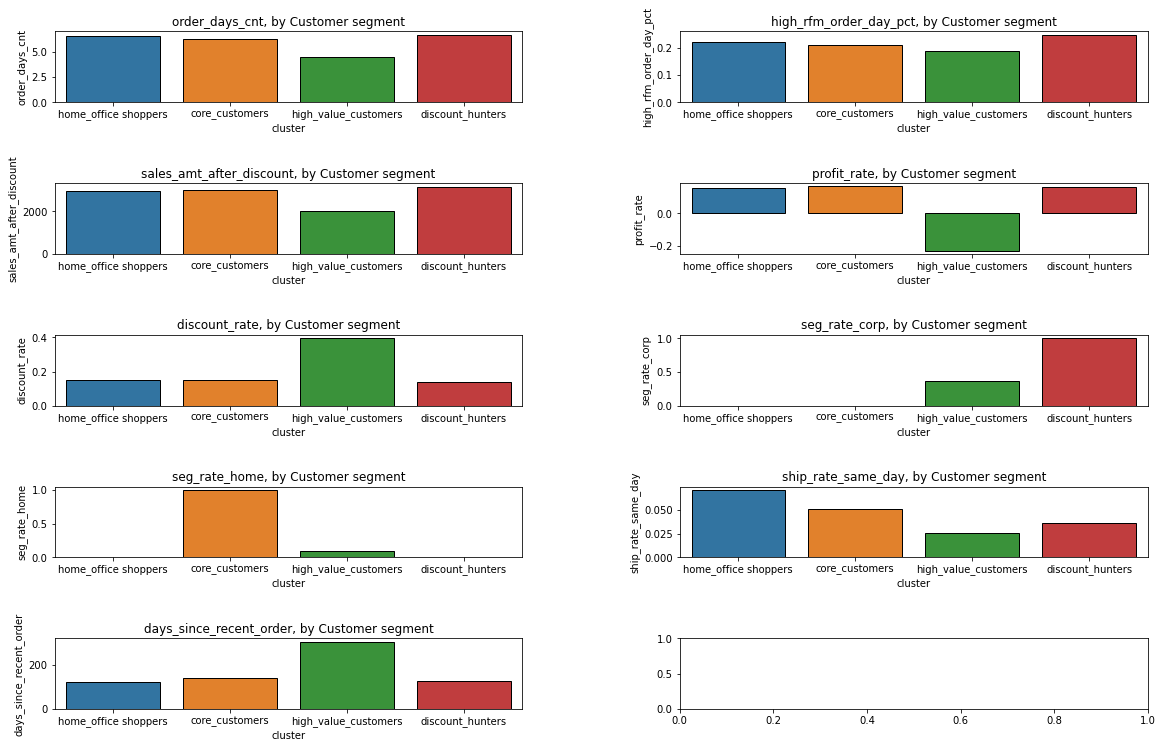

In [58]:
# re-map cluster values
ss_cust['cluster'] = ss_cust['cluster'].map({
    0: 'discount_hunters', 
    1: 'home_office shoppers', 
    2: 'high_value_customers', 
    3: 'core_customers'})

# plot attributes used for clustering
bar_plots(ss_cust, 'cluster', kmean_cols, 2)

## Conclusion

Through customer transaction analysis we were able to understand trends in overall sales, identify different types of transactions (through RFM), and segment customers into groups with distinct needs.




**<ins>*High value customers*</ins>**<br>
We found that 25% of our customers are extremely engaged and generating most of our profits.  Our main goal with these customers is retention.  Increased personalization and loyalty rewards will be key to keeping this group engaged.  Next steps for this group are to evaluate trends in engagements. We can use our wealth of transaction data with these customers to send personalized communications and promotional offers at the right time to stay top of mind and show that we value of them.  In the long-term, we should look to build a loyalty program around the needs and preferences of these customers.

**<ins>*Core customers*</ins>**<br>
Core customers make up half of our customer base.  They generate healthy profit, but don't purchase too frequently.  With this segment, we should be looking to foster growth and build stronger customer relationships. Our goal is to migrate these customers up the value chain into the *high value customers* segment.  Next steps for these customers are to understand purchase patterns and offer NPTB (next-product-to-buy) suggestions to encourage repeat visits and purchases.

**<ins>*Home-office shoppers*</ins>**<br>
While slightly more engaged than our core customer base, these customers are primarily unique in that they are specific to the home office segment.  Understanding trends in home office product sales can help inform how we communicate with these customers going forward.  Next steps may include further sub-segmentation of this closer to focus our efforts. 

**<ins>*Unprofitable Discount hunters*</ins>**<br>
This segment is relatively small - about 10% of our customers - but put a heavy tax on our bottom line.  Our goal with these customers is to either migrate them to profitability or disincent loss-leading purchases.  Placing tighter controls around which promotions are advertised to which customer segments, should be a quick win in boosting profitability with this group.